aggiungere https://www.istat.it/it/metodi-e-strumenti/web-service-sdmx

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
def calc_larg(val):

    val_sep = val.split("-")
    l = (int(val_sep[1]) - int(val_sep[0]))
    return l


def scale(x, sf, scalepars_min_x=None, scalepars_max_xp=None):
    if scalepars_min_x is None:
        scalepars_min_x = np.min(x)
    x_sc = x-scalepars_min_x
    if scalepars_max_xp is None:
        scalepars_max_xp = np.max(x_sc)
    x_sc = x_sc/scalepars_max_xp
    x_sc *= sf
    return x_sc, scalepars_min_x, scalepars_max_xp


def scale_back(x, scalepars_min_x, scalepars_max_xp):
    #global scalepars_min_x, scalepars_max_xp
    
    x_sc = x/np.max(x)
    x_sc *= scalepars_max_xp
    x_sc = x_sc+scalepars_min_x
    return x_sc

def calc_sq_diff(a, b):
    return np.sum(np.square(a-b))

no_tax = 8.174
scaglioni = np.array([ 0, 15, 28, 55, 75])
aliquote = np.array([ .23, .27, .38, .41, .43])
base = np.array([ 0, 3.450, 6.960, 17.220, 25.420])

def calc_irpef(reddito, solo_aliquota = False):
    if reddito <= no_tax:
        return 0
    
    for i_s, s in enumerate( scaglioni):
        b = base[i_s-1]
        a = aliquote[i_s-1]
        #a = aliquote[i_s]
        if reddito > s:
        #if reddito > scaglioni[i_s +1] :
            continue
            
        else:
            #print ("reddito", reddito, "scaglione", s, "aliquota", a, "base", b, "sttraggo", scaglioni[i_s-1])
            if not solo_aliquota:
                return  b + a * (reddito - scaglioni[i_s-1])
            else:
                return a
    return base[-1] + aliquote[-1] * (reddito - scaglioni[-1])

## Studio redditi dichiarati

In [2]:
# file preso da https://www1.finanze.gov.it/finanze3/analisi_stat/index.php?tree=2018AAPFTOT020602&export=0&media=media&page=1&personalizza=no
'''Tipo di imposta : IRPEF

Modello : Persone fisiche totali

Tipologia contribuente : Tutte le tipologie di contribuenti

Tematica : Calcolo dell'IRPEF

Classificazione : Classi di reddito complessivo in euro

Ammontare e media espressi in : Migliaia di euro
'''
df = pd.read_csv("irpef2.csv", delimiter=";", decimal=",", thousands=".")


In [3]:
'''def calc_vc(val):

    val_sep = val.split("-")
    vc = (int(val_sep[1]) - int(val_sep[0]))/2 + int(val_sep[0])
    return vc
df["valore_centrale"] = df['Codice'].apply(calc_vc)'''


df["larghezza"] = df['Codice'].apply(calc_larg)
df = df[df['Reddito complessivo - Media']<100]

In [103]:
colonne_interessanti = ['Classi di reddito complessivo in euro', 
                        'Numero contribuenti', 
                        'Reddito complessivo - Ammontare',
                       'Reddito complessivo - Media']
df = df[colonne_interessanti]
df.head()

,Classi di reddito complessivo in euro,Numero contribuenti,Reddito complessivo - Ammontare,Reddito complessivo - Media
0,da 0 a 1.000,2350042,991408,0.42
1,da 1.000 a 1.500,606558,753107,1.24
2,da 1.500 a 2.000,507765,887646,1.75
3,da 2.000 a 2.500,466449,1051872,2.26
4,da 2.500 a 3.000,437705,1203420,2.75


/Users/vincenzo/miniconda3/envs/py37.3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


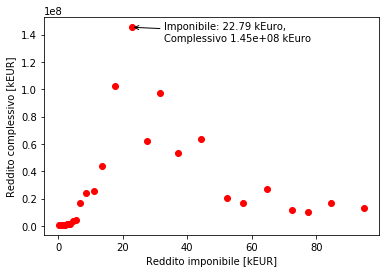

In [5]:
plt.plot(df['Reddito complessivo - Media'], df["Reddito complessivo - Ammontare"], 'ro')
plt.xlabel("Reddito imponibile [kEUR]")
plt.ylabel("Reddito complessivo [kEUR]")

max_at_pos = np.argmax (df["Reddito complessivo - Ammontare"])
x_at_max = df['Reddito complessivo - Media'][max_at_pos]
y_at_max = df["Reddito complessivo - Ammontare"][max_at_pos]
#plt.arrow(x_at_max+2000, y_at_max-0.01e+8, 8000, -0.05e+8, shape='right', head_width = 10000, head_length=10000)
plt.annotate(f"Imponibile: {x_at_max} kEuro,\nComplessivo {y_at_max :1.2e} kEuro", [x_at_max, y_at_max], xytext=(x_at_max+10, y_at_max-0.1e8), arrowprops=dict(arrowstyle="->"))
plt.show()

In [6]:
df['Numero contribuenti'].sum()

39726850

In [7]:
df['area_loc'] = df["larghezza"]* df["Reddito complessivo - Ammontare"]
area_tot = np.sum(df['area_loc'])
area_tot

4200438836500

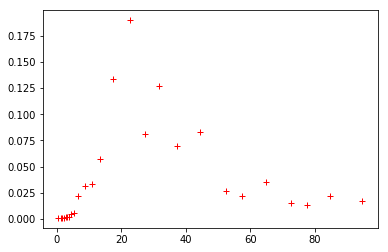

In [8]:
y_norm =  df["Reddito complessivo - Ammontare"]/area_tot
plt.plot(df['Reddito complessivo - Media'], y_norm/np.sum(y_norm), 'r+')

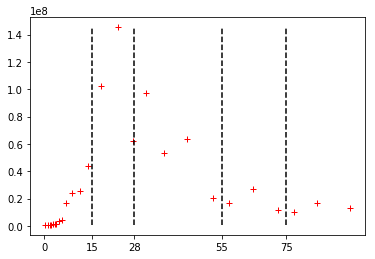

In [9]:
y4plot = df["Reddito complessivo - Ammontare"]#/1e8+2
plt.plot(df['Reddito complessivo - Media'], y4plot, 'r+')

max_y = np.max(y4plot)
min_y = np.min(y4plot)
plt.xticks(scaglioni)
for s in scaglioni:
    if s == 0:
        continue
    plt.plot([s, s], [min_y, max_y], '--', color = 'k')


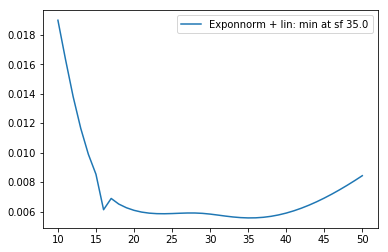

minimo in pos 25: scalato a 35.0 , valore: 0.005567674221433705


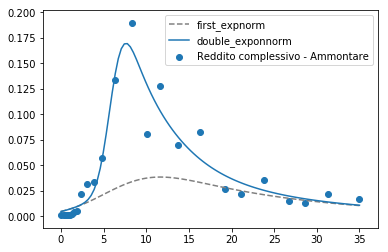

In [13]:
def double_exponnorm(x, p0, p1, p2, p3):
    return stats.exponnorm.pdf(x,  p0, p1, p2) + stats.exponnorm.pdf(x,  p0, p1, p3)

rescaled = np.linspace (10, 50, 41)

sq_errs = []
y2use = y_norm/np.sum(y_norm)
last = 100
tutti_pars = []
for sf in rescaled:
    x_sc, _, _ = scale(df['Reddito complessivo - Media'], sf)
    initial = [5, 3, 0.8, 0.4]
    try:
        pars, cov = curve_fit(double_exponnorm, x_sc, y2use, p0 = initial)#, bounds=bounds)
        tutti_pars .append(pars)
        sq_err = calc_sq_diff(double_exponnorm(x_sc, pars[0], pars[1], pars[2], pars[3]), y2use)
        sq_errs.append(sq_err)
        last = sq_err
    except RuntimeError:
        sq_errs.append(last)
min_at=np.argmin(sq_errs)
sf_scelto = rescaled[min_at]
errore = sq_errs[min_at]
pars_scelti = tutti_pars[min_at]

plt.plot(rescaled, sq_errs, label = f"Exponnorm + lin: min at sf {sf_scelto}")
plt.legend()
plt.show()


print (f"minimo in pos {min_at}: scalato a {sf_scelto} , valore: {errore}")

xt = np.linspace(0, sf_scelto, 100)
y1 = stats.exponnorm.pdf(xt, pars_scelti[0], pars_scelti[1], pars_scelti[2])
yt = double_exponnorm(xt, pars_scelti[0], pars_scelti[1], pars_scelti[2], pars_scelti[3])

plt.plot(xt, y1, '--', label='first_expnorm', color = 'grey')
plt.plot(xt, yt, label="double_exponnorm")

x_sc, sc_min, sc_max = scale(df['Reddito complessivo - Media'], sf_scelto)
plt.scatter(x_sc, y2use)
plt.legend()
plt.show()



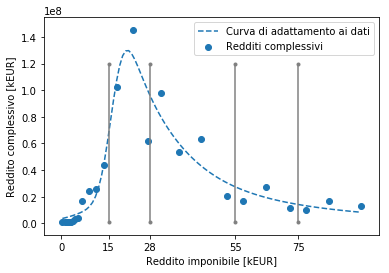

In [14]:
xt = np.linspace(0, sf_scelto, 100)
xt_sc_b = scale_back(xt, sc_min, sc_max)
yt = double_exponnorm(xt, pars_scelti[0], pars_scelti[1], pars_scelti[2], pars_scelti[3])
y_scale_bac_fac = area_tot * np.sum(y_norm)

plt.plot(xt_sc_b, yt*y_scale_bac_fac, "--", label="Curva di adattamento ai dati")
plt.scatter(df['Reddito complessivo - Media'], y2use* y_scale_bac_fac, label="Redditi complessivi")
plt.legend()
plt.xlabel("Reddito imponibile [kEUR]")
plt.ylabel("Reddito complessivo [kEUR]")
max_y = np.max(y2use)
min_y = np.min(y2use)
plt.xticks(scaglioni)
for s in scaglioni:
    if s == 0:
        continue
    plt.plot([s, s], [min_y*y_scale_bac_fac, 1.2e8], '.-', color = 'gray')
plt.show()

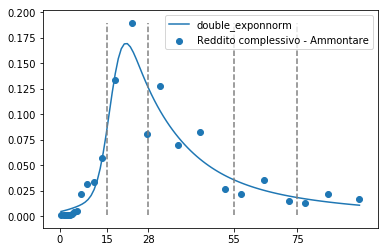

In [20]:

xt = np.linspace(0, sf_scelto, 100)
xt_sc_b = scale_back(xt, sf_scelto)
yt = double_exponnorm(xt, pars_scelti[0], pars_scelti[1], pars_scelti[2], pars_scelti[3])

plt.plot(xt_sc_b, yt, label="double_exponnorm")

x_sc = scale(df['Reddito complessivo - Media'], sf_scelto)
plt.scatter(df['Reddito complessivo - Media'], y2use)
plt.legend()
max_y = np.max(y2use)
min_y = np.min(y2use)
plt.xticks(scaglioni)
for s in scaglioni:
    if s == 0:
        continue
    plt.plot([s, s], [min_y, max_y], '--', color = 'gray')
plt.show()

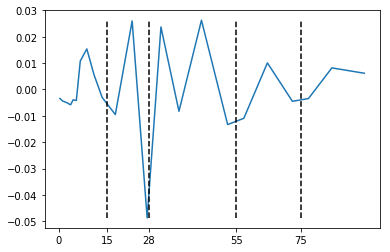

In [15]:
pars_scelti = np.array([3.69957129, 5.87470515, 4.25561841, 1.2146135 ])

baseline =  double_exponnorm(x_sc, pars_scelti[0], pars_scelti[1], pars_scelti[2], pars_scelti[3])
dati_m_baseline = y2use - baseline
x_sc_b = scale_back(x_sc, sc_min, sc_max)
plt.plot(x_sc_b, dati_m_baseline)
max_y = np.max(dati_m_baseline)
min_y = np.min(dati_m_baseline)
plt.xticks(scaglioni)
for s in scaglioni:
    if s == 0:
        continue
    plt.plot([s, s], [min_y, max_y], '--', color = 'k')
plt.show()

## da scaglioni a continua

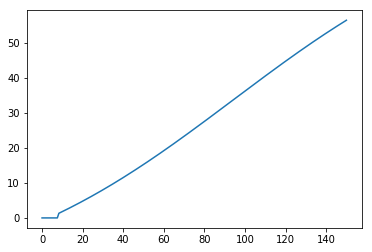

In [248]:


def calc_nuova_irpef(x, p0, p1, p2, sc_min, sc_max, coda_vecchia = False):
    zeros = x>no_tax
    x_scaled, _, _ = scale(x, 1, sc_min, sc_max )
    calculated = fit_tax(x_scaled, p0, p1, p2) * zeros
    if coda_vecchia is False:
        return calculated
    tokeep_pos = np.argmin(x<75)
    high_income = []
    for data in x[tokeep_pos:]:
        high_income.append(calc_irpef(data))

    # eliminiamo discontinuità
    last_tokeep = calculated[tokeep_pos]
    
    salto = last_tokeep-high_income[0]
    #print ( last_tokeep, high_income[0], salto)
    #print (high_income)
    high_income += salto
    print(salto)
    #print (high_income)

    exp_calc = np.concatenate([calculated[:tokeep_pos], high_income])
    
    return exp_calc

y_temp = calc_nuova_irpef(ascisse_cont, pars[0], pars[1], pars[2], fit_sc_min, fit_sc_max)
plt.plot(ascisse_cont, y_temp)

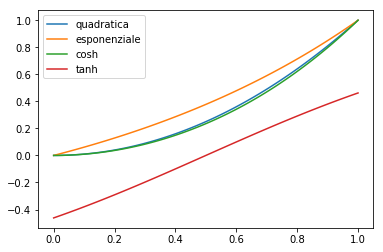

In [223]:
# confronto 
x= np.linspace(0,1, 100)

y_q = np.square(x)
y_q -= y_q[0]
y_q /= np.max(y_q)

y_e = np.exp(x)
y_e -= y_e[0]
y_e /=np.max(y_e)

y_ch = np.cosh(x)
y_ch -= y_ch[0]
y_ch /= np.max(y_ch)

y_th = np.tanh(x-0.5)

plt.plot(x, y_q, label = "quadratica")
plt.plot(x, y_e, label = "esponenziale")
plt.plot(x, y_ch, label = "cosh")
plt.plot(x, y_th, label = "tanh")
plt.legend()

parametri [39.00193497 65.69527392 -0.71226775]


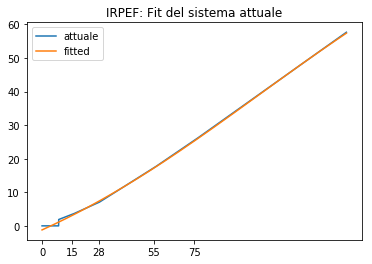

In [313]:
def fit_tax(x, p0, p1, p2, val_hi=None):
    if val_hi is not None:
        bias_hi = np.dot(x>val_hi, 0.1)
        return p0+p1*np.tanh(p2+x)+ bias_hi
    return p0+p1*np.tanh(p2+x)
    # return p0+p1*np.tanh(p2+x) #prima tanh
    #return p0+np.cosh((x+p1)*p2) # coseno iperbolico
    #return p0+p1*x+p2*np.square(x) #quadratica
    #return p0+np.exp((x+p1)*p2) #esponenziale
    
weighted = False

x=np.linspace(0, 150, 10000)
y= []
for x_i in x:
    y.append(calc_irpef(x_i))
    
    
x_sc, fit_sc_min, fit_sc_max = scale(x, 1)

# il valore oltre al quale aggiungiamo un bias, per far quadrare i conti
val_hi_raw = 75
val_hi, _, _ = scale(x, 1, fit_sc_min, fit_sc_max)
f = lambda x, p0, p1, p2: fit_tax(x, p0, p1, p2, val_hi=-val_hi)

if weighted:
    weights = 1/x_sc
    for i in range(len(x_sc)//2): 
        weights[i] = weights[len(x_sc)//2 +1]
    
    pars, covs = curve_fit(f, x_sc, y, sigma=weights)
else:
    pars, covs = curve_fit(f, x_sc, y)
print('parametri', pars)

plt.plot(x, y, label='attuale')
y_fit = fit_tax(x_sc, *pars)
plt.plot(x, y_fit, label="fitted")
plt.xticks(scaglioni)
plt.title("IRPEF: Fit del sistema attuale")
plt.legend()
plt.show() #parametri [39.10162615 65.69521912 -0.71226283]

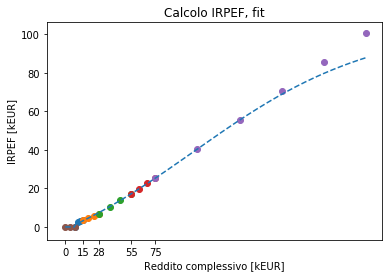

In [269]:
con_fit = True
max_red = 250 # np.max(df['Reddito complessivo - Media']
for i_sc, scaglione in enumerate(scaglioni):
    if i_sc<4:
        x = np.linspace(np.max([scaglione, no_tax]), scaglioni[i_sc+1], 4)
    elif i_sc == 4:
        x = np.linspace(scaglioni[-1], max_red, 6)
    else:
        x = np.linspace(0, no_tax, 2)
    y = []
    for x_i in x:
        y.append(calc_irpef(x_i))
    plt.scatter(x, y)
    
x = np.linspace(0, no_tax, 3)
y = []
for x_i in x:
    y.append(calc_irpef(x_i))
plt.scatter(x, y)
    
    
    
if con_fit:
    ascisse_cont = np.linspace(0, max_red, 200) 
    nuova_irpef = (calc_nuova_irpef(ascisse_cont, pars[0], pars[1], pars[2], fit_sc_min, fit_sc_max))
    plt.plot(ascisse_cont, nuova_irpef, '--', label='nuova')

    
plt.xlabel("Reddito complessivo [kEUR]")
plt.ylabel("IRPEF [kEUR]")
if con_fit:
    plt.title("Calcolo IRPEF, fit")
else:
    plt.title("Calcolo IRPEF, sistema attuale")
plt.xticks(scaglioni)
plt.show()




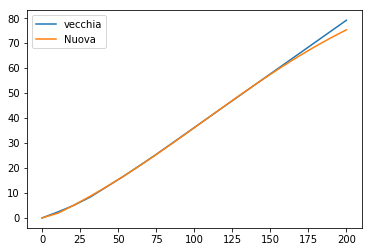

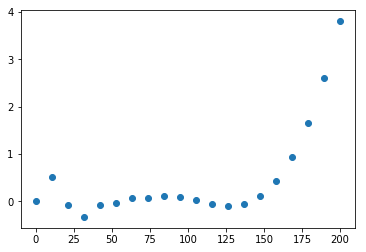

In [270]:
x = np.linspace(0, 200, 20)
y = []
for x_i in x:
    y.append(calc_irpef(x_i))
    
plt.plot(x, y, label = "vecchia")
plt.plot(x, calc_nuova_irpef(x, pars[0], pars[1], pars[2], fit_sc_min, fit_sc_max), label = "Nuova")
plt.legend()
plt.show()
plt.scatter(x, y - calc_nuova_irpef(x, pars[0], pars[1], pars[2], fit_sc_min, fit_sc_max))

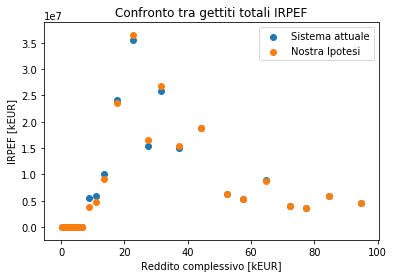

In [275]:
# calcolo entrate totali per lo stato

irpef_tot_attuali = []
irpef_tot_continua = calc_nuova_irpef(df['Reddito complessivo - Media'].values, *pars, fit_sc_min, fit_sc_max)
nc = df['Numero contribuenti'].values

for i_rcm, rcm in df['Reddito complessivo - Media'].iteritems():
    irpef_tot_attuali.append(calc_irpef(rcm))
    
    
plt.scatter(df['Reddito complessivo - Media'], irpef_tot_attuali*nc, label = 'Sistema attuale')
plt.scatter(df['Reddito complessivo - Media'], irpef_tot_continua*nc, label = 'Nostra Ipotesi')

plt.xlabel("Reddito complessivo [kEUR]")
plt.ylabel("IRPEF [kEUR]")
plt.title("Confronto tra gettiti totali IRPEF")
plt.legend()

In [276]:
np.sum(irpef_tot_attuali), np.sum(irpef_tot_continua)

(226.04740000000004, 225.20815170715886)

In [273]:
irpef_tot_attuali[-1], irpef_tot_continua[-1]

(33.886700000000005, 33.79217073272867)